# Overview

Our goal was to develop a model with high accuracy and precision that can be used to inform targeted outreach efforts. We created a random forest model with a precision score of .7807 to predict which patients are likely to get the seasonal vaccine. 

# Buisness Problem

The Centers for Disease Control and Prevention (CDC) has identified low vaccination rates as a major public health concern, particularly for seasonal flu. According to the World Health Organization (WHO), the seasonal flu causes 3 to 5 million cases of severe illness and about 290,000 to 650,000 respiratory-related deaths worldwide each year. In the United States alone, the Centers for Disease Control and Prevention (CDC) estimates that the seasonal flu has resulted in between 9 million to 45 million illnesses, 140,000 to 810,000 hospitalizations, and 12,000 to 61,000 deaths annually since 2010.

Despite the availability and efficacy of the seasonal flu vaccine, many individuals still do not receive it each year. The Flatiron Hospital is interested in improving vaccination rates among its patient population. To do so, we want to develop a model that can predict which patients are most likely to receive the seasonal flu vaccine, based on their demographics, behaviors, and beliefs about vaccination. By targeting these high-risk individuals with personalized messaging and reminders, we hope to increase vaccination rates and improve public health outcomes. 

# Data Understanding

In late 2009 and early 2010, the United States conducted the National 2009 H1N1 Flu Survey.
This phone survey asked respondents whether they had received the H1N1 and seasonal flu vaccines, in conjunction with questions about themselves. These additional questions covered their social, economic, and demographic background, opinions on risks of illness and vaccine effectiveness, and behaviors towards mitigating transmission. The dataset includes 35 different features and a total of 26707 data entries. More information on the dataset can be found here (https://www.drivendata.org/competitions/66/flu-shot-learning/page/211/). 

## IMPORTS

In [98]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [248]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold

from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.naive_bayes import MultinomialNB, GaussianNB

from sklearn.metrics import (plot_confusion_matrix, classification_report, confusion_matrix, 
                             plot_roc_curve, accuracy_score, precision_score)

from sklearn.model_selection import GridSearchCV

In [100]:
# setting the theme, palette, size for all plots made in this notebook
sns.set_theme()
sns.set_palette('colorblind')
sns.set(rc = {'figure.figsize':(13,7)})

In [ ]:
pd.__version__

## Reading in the datasets

In [101]:
training_f = pd.read_csv('data/training_set_features.csv', index_col='respondent_id')
training_l = pd.read_csv('data/training_set_labels.csv', index_col='respondent_id')
test_f = pd.read_csv('data/test_set_features.csv', index_col='respondent_id')
submission_format = pd.read_csv('data/submission_format.csv')

## Training set features

In [102]:
display(training_f)
display(training_f.info())
display(training_f.describe())

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,qufhixun,Non-MSA,0.0,0.0,NaN,NaN
26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,"<= $75,000, Above Poverty",Not Married,Rent,Employed,lzgpxyit,"MSA, Principle City",1.0,0.0,fcxhlnwr,cmhcxjea
26704,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,NaN,Not Married,Own,NaN,lzgpxyit,"MSA, Not Principle City",0.0,0.0,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26615 non-null  float64
 1   h1n1_knowledge               26591 non-null  float64
 2   behavioral_antiviral_meds    26636 non-null  float64
 3   behavioral_avoidance         26499 non-null  float64
 4   behavioral_face_mask         26688 non-null  float64
 5   behavioral_wash_hands        26665 non-null  float64
 6   behavioral_large_gatherings  26620 non-null  float64
 7   behavioral_outside_home      26625 non-null  float64
 8   behavioral_touch_face        26579 non-null  float64
 9   doctor_recc_h1n1             24547 non-null  float64
 10  doctor_recc_seasonal         24547 non-null  float64
 11  chronic_med_condition        25736 non-null  float64
 12  child_under_6_months         25887 non-null  float64
 13  health_worker   

None

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children
count,26615.000000,26591.000000,26636.000000,26499.000000,26688.000000,26665.000000,26620.00000,26625.000000,26579.000000,24547.000000,...,25903.000000,14433.00000,26316.000000,26319.000000,26312.000000,26245.000000,26193.000000,26170.000000,26458.000000,26458.000000
mean,1.618486,1.262532,0.048844,0.725612,0.068982,0.825614,0.35864,0.337315,0.677264,0.220312,...,0.111918,0.87972,3.850623,2.342566,2.357670,4.025986,2.719162,2.118112,0.886499,0.534583
std,0.910311,0.618149,0.215545,0.446214,0.253429,0.379448,0.47961,0.472802,0.467531,0.414466,...,0.315271,0.32530,1.007436,1.285539,1.362766,1.086565,1.385055,1.332950,0.753422,0.928173
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,1.00000,3.000000,1.000000,1.000000,4.000000,2.000000,1.000000,0.000000,0.000000
50%,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.00000,0.000000,1.000000,0.000000,...,0.000000,1.00000,4.000000,2.000000,2.000000,4.000000,2.000000,2.000000,1.000000,0.000000
75%,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.00000,1.000000,1.000000,0.000000,...,0.000000,1.00000,5.000000,4.000000,4.000000,5.000000,4.000000,4.000000,1.000000,1.000000
max,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,...,1.000000,1.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,3.000000


## Training set labels

In [103]:
display(training_l)
display(training_l.info())
display(training_l.describe())

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
0,0,0
1,0,1
2,0,0
3,0,1
4,0,0
...,...,...
26702,0,0
26703,0,0
26704,0,1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   h1n1_vaccine      26707 non-null  int64
 1   seasonal_vaccine  26707 non-null  int64
dtypes: int64(2)
memory usage: 625.9 KB


None

,h1n1_vaccine,seasonal_vaccine
count,26707.000000,26707.000000
mean,0.212454,0.465608
std,0.409052,0.498825
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,1.000000
max,1.000000,1.000000


## Test set features

In [104]:
display(test_f)
display(test_f.info())

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
26707,2.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,"> $75,000",Not Married,Rent,Employed,mlyzmhmf,"MSA, Not Principle City",1.0,0.0,atmlpfrs,hfxkjkmi
26708,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,Non-MSA,3.0,0.0,atmlpfrs,xqwwgdyp
26709,2.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,...,"> $75,000",Married,Own,Employed,lrircsnp,Non-MSA,1.0,0.0,nduyfdeo,pvmttkik
26710,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,"<= $75,000, Above Poverty",Married,Own,Not in Labor Force,lrircsnp,"MSA, Not Principle City",1.0,0.0,NaN,NaN
26711,3.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,lzgpxyit,Non-MSA,0.0,1.0,fcxhlnwr,mxkfnird
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53410,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,dqpwygqj,"MSA, Principle City",1.0,1.0,NaN,NaN
53411,3.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,Below Poverty,Married,Rent,Employed,qufhixun,Non-MSA,1.0,3.0,fcxhlnwr,vlluhbov
53412,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,qufhixun,"MSA, Not Principle City",1.0,0.0,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 26708 entries, 26707 to 53414
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26623 non-null  float64
 1   h1n1_knowledge               26586 non-null  float64
 2   behavioral_antiviral_meds    26629 non-null  float64
 3   behavioral_avoidance         26495 non-null  float64
 4   behavioral_face_mask         26689 non-null  float64
 5   behavioral_wash_hands        26668 non-null  float64
 6   behavioral_large_gatherings  26636 non-null  float64
 7   behavioral_outside_home      26626 non-null  float64
 8   behavioral_touch_face        26580 non-null  float64
 9   doctor_recc_h1n1             24548 non-null  float64
 10  doctor_recc_seasonal         24548 non-null  float64
 11  chronic_med_condition        25776 non-null  float64
 12  child_under_6_months         25895 non-null  float64
 13  health_worke

None

training set features has 26707 rows × 35 columns and training set labels has 26707 rows × 2 columns. The respoondent_id seems to be the same but we do not know for sure.

The testing set features has 26708 rows × 35 columns. The columns are all the same from the training. 

There seems to be null values for some of the columns which will need to be taken care of.

## Checking target and if there is a class imbalance

In [105]:
display(training_l['h1n1_vaccine'].value_counts())
display(training_l['h1n1_vaccine'].value_counts(normalize=True))

0    21033
1     5674
Name: h1n1_vaccine, dtype: int64

0    0.787546
1    0.212454
Name: h1n1_vaccine, dtype: float64

In [106]:
display(training_l['seasonal_vaccine'].value_counts())
display(training_l['seasonal_vaccine'].value_counts(normalize=True))

0    14272
1    12435
Name: seasonal_vaccine, dtype: int64

0    0.534392
1    0.465608
Name: seasonal_vaccine, dtype: float64

I will decide to use seasonal vaccine as my target since there seems to be very little class inbalance.

In [107]:
training_l.drop('h1n1_vaccine', axis=1, inplace=True)
training_l

,seasonal_vaccine
respondent_id,
0,0
1,1
2,0
3,1
4,0
...,...
26702,0
26703,0
26704,1


# Exploratory Data Analysis

## Numpy's assert_array_equal
Using the numpy assert_array_equal to double-check that the rows between the features and the labels match up. 
We don't want to have the wrong labels. 
Numpy's assert_array_equal will error if the two arrays—the row indices of the two data frames—don't match up.

 -- This was taken from DRIVENDATA's benchmark blog post for this dataset.

In [108]:
np.testing.assert_array_equal(training_f.index.values, training_l.index.values)

Since the assert ran with no errors, it means that the values match for training features and labels.

## Data Cleaning

In [109]:
training_f.isna().sum()

h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
marital_status                  1408
r

In [110]:
# looking at the percentage missing for each column so I can decide which ones to drop
for col in training_f.columns:
    print(f'{col} is missing {training_f[col].isna().sum() / len(training_f.index) * 100:.2f}% of its values')

h1n1_concern is missing 0.34% of its values
h1n1_knowledge is missing 0.43% of its values
behavioral_antiviral_meds is missing 0.27% of its values
behavioral_avoidance is missing 0.78% of its values
behavioral_face_mask is missing 0.07% of its values
behavioral_wash_hands is missing 0.16% of its values
behavioral_large_gatherings is missing 0.33% of its values
behavioral_outside_home is missing 0.31% of its values
behavioral_touch_face is missing 0.48% of its values
doctor_recc_h1n1 is missing 8.09% of its values
doctor_recc_seasonal is missing 8.09% of its values
chronic_med_condition is missing 3.64% of its values
child_under_6_months is missing 3.07% of its values
health_worker is missing 3.01% of its values
health_insurance is missing 45.96% of its values
opinion_h1n1_vacc_effective is missing 1.46% of its values
opinion_h1n1_risk is missing 1.45% of its values
opinion_h1n1_sick_from_vacc is missing 1.48% of its values
opinion_seas_vacc_effective is missing 1.73% of its values
opin

In [111]:
for col in training_f.columns:
    percent_missing = training_f[col].isna().sum() / len(training_f.index) * 100
    if percent_missing > 30:
        print(f'{col} is missing {percent_missing:.2f}% of its values.')
#    else:
#        print(f'{col} is missing less than 30% of its data.')

health_insurance is missing 45.96% of its values.
employment_industry is missing 49.91% of its values.
employment_occupation is missing 50.44% of its values.


It seems like the above three columns are missing more than 45% of its values so I will just drop these columns instead of filling in the missing data.

In [112]:
training_f.drop(columns=['health_insurance', 'employment_industry', 'employment_occupation'], inplace=True)
training_f

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,White,Female,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,qufhixun,Non-MSA,0.0,0.0
26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,White,Male,"<= $75,000, Above Poverty",Not Married,Rent,Employed,lzgpxyit,"MSA, Principle City",1.0,0.0
26704,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,White,Female,NaN,Not Married,Own,NaN,lzgpxyit,"MSA, Not Principle City",0.0,0.0


In [113]:
# sanity check
training_f.isna().sum()

h1n1_concern                     92
h1n1_knowledge                  116
behavioral_antiviral_meds        71
behavioral_avoidance            208
behavioral_face_mask             19
behavioral_wash_hands            42
behavioral_large_gatherings      87
behavioral_outside_home          82
behavioral_touch_face           128
doctor_recc_h1n1               2160
doctor_recc_seasonal           2160
chronic_med_condition           971
child_under_6_months            820
health_worker                   804
opinion_h1n1_vacc_effective     391
opinion_h1n1_risk               388
opinion_h1n1_sick_from_vacc     395
opinion_seas_vacc_effective     462
opinion_seas_risk               514
opinion_seas_sick_from_vacc     537
age_group                         0
education                      1407
race                              0
sex                               0
income_poverty                 4423
marital_status                 1408
rent_or_own                    2042
employment_status           

In [115]:
training_f_l = training_l.join(training_f)

In [116]:
training_f_l

,seasonal_vaccine,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0
2,0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0
3,1,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0
4,0,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,White,Female,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,qufhixun,Non-MSA,0.0,0.0
26703,0,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,White,Male,"<= $75,000, Above Poverty",Not Married,Rent,Employed,lzgpxyit,"MSA, Principle City",1.0,0.0
26704,1,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,White,Female,NaN,Not Married,Own,NaN,lzgpxyit,"MSA, Not Principle City",0.0,0.0


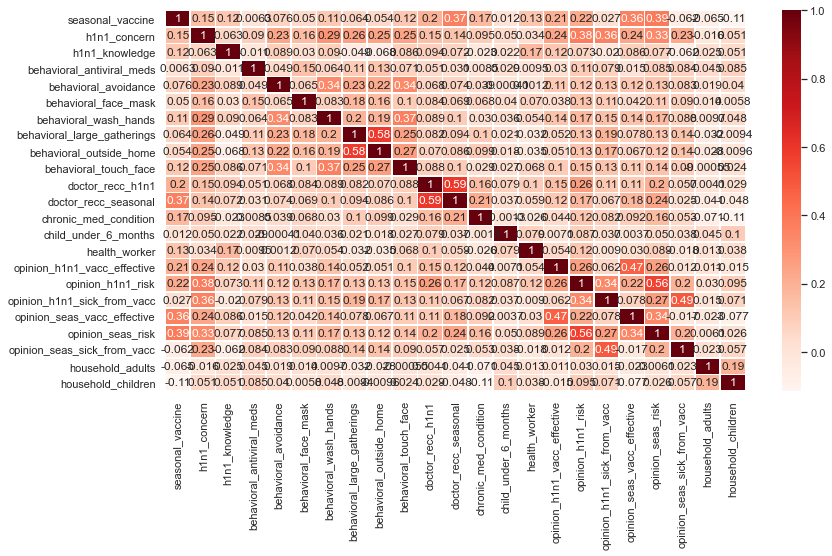

In [117]:
# creating dataset correlation heatmap
sns.heatmap(training_f_l.corr(), cmap='Reds', annot=True, linewidths=.7);

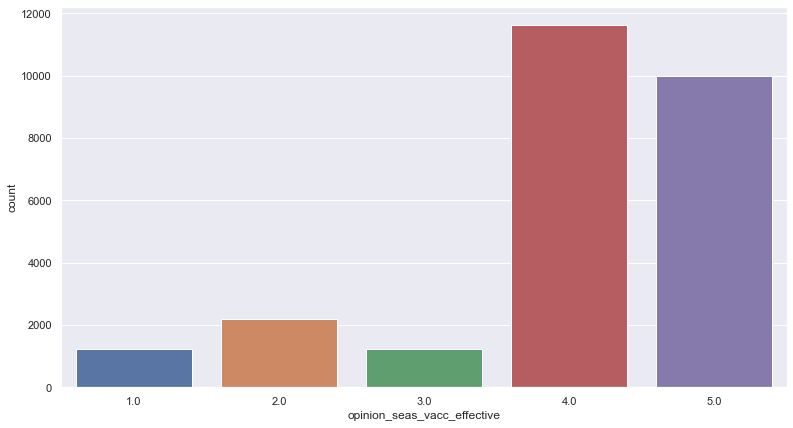

In [118]:
sns.countplot(x = 'opinion_seas_vacc_effective', data = training_f);

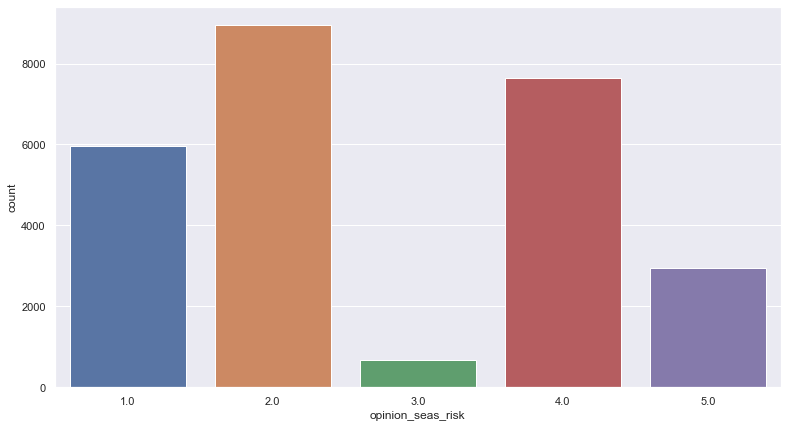

In [119]:
sns.countplot(x = 'opinion_seas_risk', data = training_f);

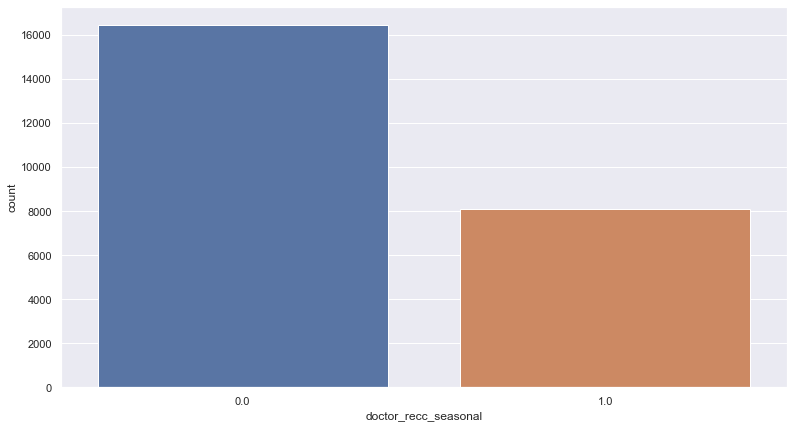

In [120]:
sns.countplot(x = 'doctor_recc_seasonal', data = training_f);

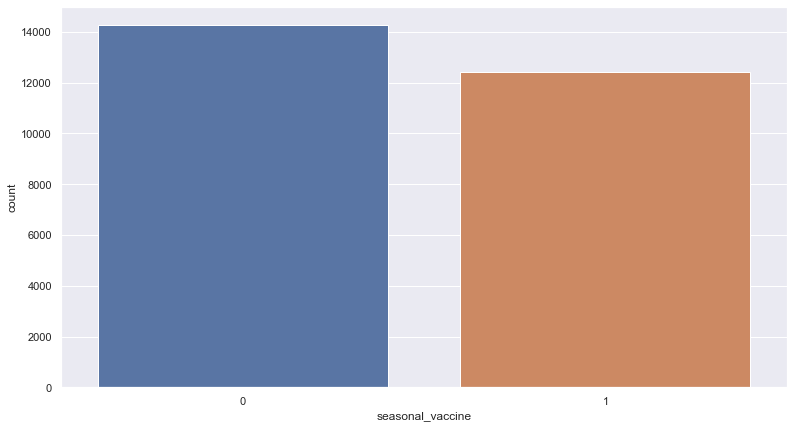

In [121]:
sns.countplot(x = 'seasonal_vaccine', data = training_l);

This will create a bar plot with doctor's recommendation on the x-axis, and the number of people with each vaccination status (0 or 1) represented by different colors. The legend will indicate which color corresponds to which vaccination status.

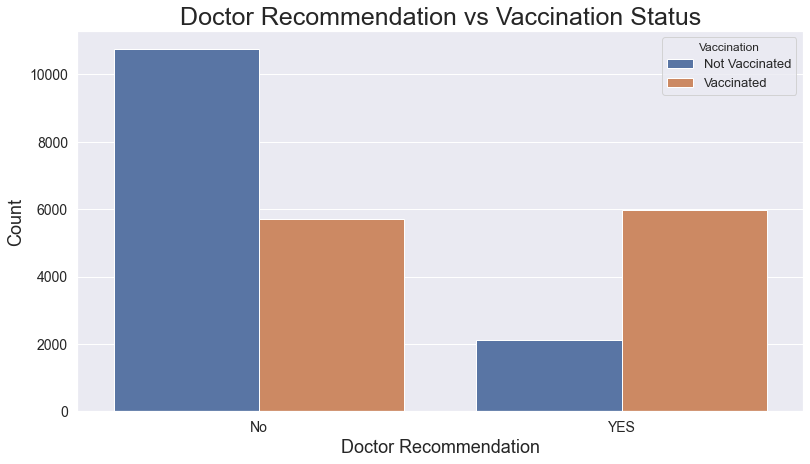

In [460]:
# Creating a count plot of doctor's recommendation vs vaccination status
sns.countplot(x='doctor_recc_seasonal', hue='seasonal_vaccine', data=training_f_l)

# Set the labels for the plot
plt.xlabel('Doctor Recommendation', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.title('Doctor Recommendation vs Vaccination Status', fontsize=25)
plt.xticks(ticks=[0,1], labels=['No', 'YES'], fontsize=14)
plt.yticks(fontsize=14)

# make the legend
plt.legend(title='Vaccination', loc='upper right', labels=['Not Vaccinated', 'Vaccinated'], fontsize=13)

# plt.savefig('images/doctor_rec.png')

In [ ]:
training_f_l['doctor_recc_seasonal'].value_counts()

In [ ]:
# value count of vaccine for people who got a doctors rec
training_f_l.loc[training_f_l['doctor_recc_seasonal'] == 1, 'seasonal_vaccine'].value_counts(normalize=True)

In [ ]:
# value count of vaccine for people who did not get a doctors rec
training_f_l.loc[training_f_l['doctor_recc_seasonal'] == 0, 'seasonal_vaccine'].value_counts(normalize=True)

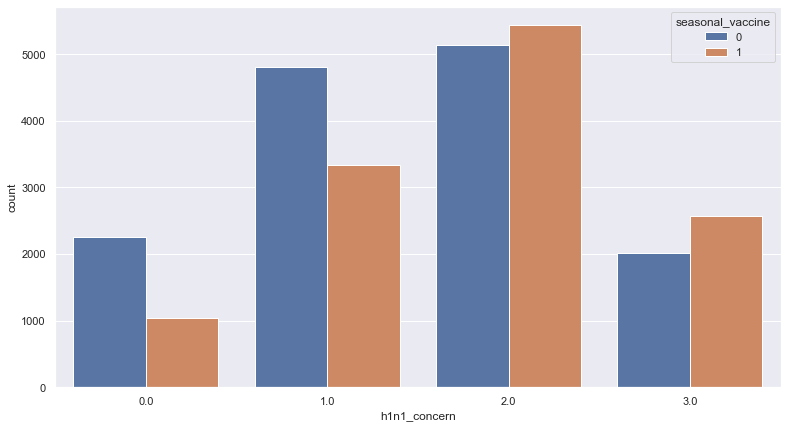

In [123]:
sns.countplot(x='h1n1_concern', hue='seasonal_vaccine', data = training_f_l);

''

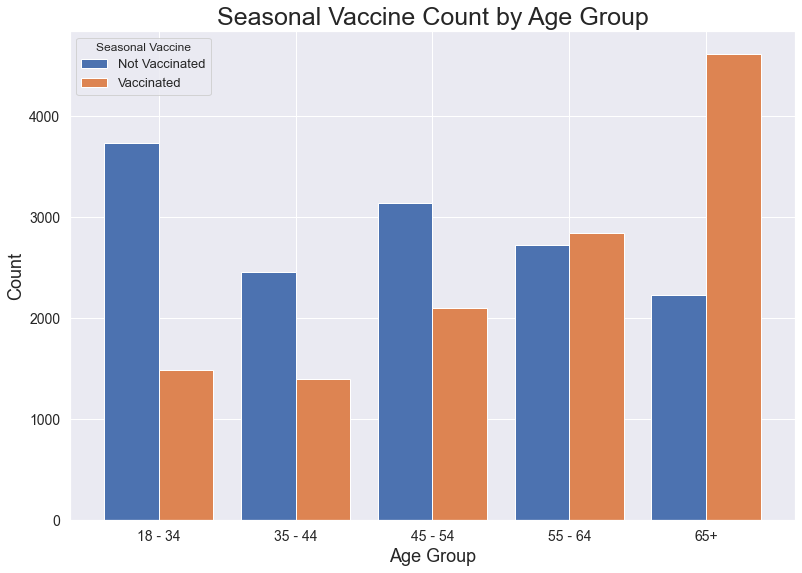

In [461]:
# Define x-axis labels
age_order = ['18 - 34', '35 - 44', '45 - 54', '55 - 64', '65+']

# Create sample data
age_group_seasonal_vaccine = training_f_l.groupby(['age_group', 'seasonal_vaccine']).size().unstack()

# Create the bar plots
#fig, ax = plt.subplots(figsize=(13,9))

ax = age_group_seasonal_vaccine.plot(kind='bar', width=0.8, figsize=(13,9), fontsize=14)
#plt.bar(age_order, age_group_seasonal_vaccine, width=0.8)

# Set the axis labels and title
ax.set_title('Seasonal Vaccine Count by Age Group', fontsize=25)

ax.set_xticklabels(age_order, rotation=0, fontsize=14)

ax.set_xlabel('Age Group', fontsize=18)
ax.set_ylabel('Count', fontsize=18)
ax.legend(title='Seasonal Vaccine', labels=['Not Vaccinated', 'Vaccinated'], fontsize=13)

# Set the axis labels and title
#plt.title('Seasonal Flu Vaccine Count by Age Group', fontsize-25)
#plt.xlabel('Age Group', fontsize=18)
#plt.ylabel('Count', fontsize=18)
#plt.xticks(fontsize=14)
#plt.yticks(fontsize=14)

#ax.legend(title='Seasonal Vaccine', labels=['Not Vaccinated', 'Vaccinated'], fontsize=14)

# plt.savefig('images/age.png')
;

## Looking at the differerent categories for each feature

In [128]:
# Looping over each numeric feature and printing its unique values
for feature in numerical_features:
    print(feature)
    print(training_f[feature].unique())

h1n1_concern
[ 1.  3.  2.  0. nan]
h1n1_knowledge
[ 0.  2.  1. nan]
behavioral_antiviral_meds
[ 0.  1. nan]
behavioral_avoidance
[ 0.  1. nan]
behavioral_face_mask
[ 0.  1. nan]
behavioral_wash_hands
[ 0.  1. nan]
behavioral_large_gatherings
[ 0.  1. nan]
behavioral_outside_home
[ 1.  0. nan]
behavioral_touch_face
[ 1.  0. nan]
doctor_recc_h1n1
[ 0. nan  1.]
doctor_recc_seasonal
[ 0. nan  1.]
chronic_med_condition
[ 0.  1. nan]
child_under_6_months
[ 0.  1. nan]
health_worker
[ 0.  1. nan]
opinion_h1n1_vacc_effective
[ 3.  5.  4.  2.  1. nan]
opinion_h1n1_risk
[ 1.  4.  3.  2.  5. nan]
opinion_h1n1_sick_from_vacc
[ 2.  4.  1.  5.  3. nan]
opinion_seas_vacc_effective
[ 2.  4.  5.  3.  1. nan]
opinion_seas_risk
[ 1.  2.  4.  3.  5. nan]
opinion_seas_sick_from_vacc
[ 2.  4.  1.  5. nan  3.]
household_adults
[ 0.  2.  1.  3. nan]
household_children
[ 0.  3.  2.  1. nan]


In [129]:
# Looping over each object feature and printing its unique values
for feature in categorical_features:
    print(feature)
    print(training_f[feature].unique())

age_group
['55 - 64 Years' '35 - 44 Years' '18 - 34 Years' '65+ Years'
 '45 - 54 Years']
education
['< 12 Years' '12 Years' 'College Graduate' 'Some College' nan]
race
['White' 'Black' 'Other or Multiple' 'Hispanic']
sex
['Female' 'Male']
income_poverty
['Below Poverty' '<= $75,000, Above Poverty' '> $75,000' nan]
marital_status
['Not Married' 'Married' nan]
rent_or_own
['Own' 'Rent' nan]
employment_status
['Not in Labor Force' 'Employed' 'Unemployed' nan]
hhs_geo_region
['oxchjgsf' 'bhuqouqj' 'qufhixun' 'lrircsnp' 'atmpeygn' 'lzgpxyit'
 'fpwskwrf' 'mlyzmhmf' 'dqpwygqj' 'kbazzjca']
census_msa
['Non-MSA' 'MSA, Not Principle  City' 'MSA, Principle City']


## Not using the pipeline and doing manually

In [130]:
# create a new dataframe called clean_training_f
clean_training_f = pd.DataFrame()

# fill missing values for numerical features
for col in numerical_features:
    clean_training_f[col] = training_f[col].fillna(training_f[col].median())

# fill missing values for categorical features
for col in categorical_features:
    clean_training_f[col] = training_f[col].fillna(value='no category')

In [131]:
clean_training_f

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City"
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City"
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City"
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,65+ Years,Some College,White,Female,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,qufhixun,Non-MSA
26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Rent,Employed,lzgpxyit,"MSA, Principle City"
26704,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,55 - 64 Years,Some College,White,Female,no category,Not Married,Own,no category,lzgpxyit,"MSA, Not Principle City"


In [132]:
clean_training_f.isna().sum()

h1n1_concern                   0
h1n1_knowledge                 0
behavioral_antiviral_meds      0
behavioral_avoidance           0
behavioral_face_mask           0
behavioral_wash_hands          0
behavioral_large_gatherings    0
behavioral_outside_home        0
behavioral_touch_face          0
doctor_recc_h1n1               0
doctor_recc_seasonal           0
chronic_med_condition          0
child_under_6_months           0
health_worker                  0
opinion_h1n1_vacc_effective    0
opinion_h1n1_risk              0
opinion_h1n1_sick_from_vacc    0
opinion_seas_vacc_effective    0
opinion_seas_risk              0
opinion_seas_sick_from_vacc    0
household_adults               0
household_children             0
age_group                      0
education                      0
race                           0
sex                            0
income_poverty                 0
marital_status                 0
rent_or_own                    0
employment_status              0
hhs_geo_re

In [ ]:
# Looping over each numeric feature and printing its unique values
for feature in numerical_features:
    print(feature)
    print(clean_training_f[feature].unique())

In [ ]:
# Looping over each object feature and printing its unique values
for feature in categorical_features:
    print(feature)
    print(clean_training_f[feature].unique())

In [ ]:
ordinal_col = ['age_group']

In [ ]:
nominal_col = np.array(categorical_features)
nominal_col = np.delete(categorical_features, np.where(categorical_features == 'age_group'))

nominal_col

In [133]:
# Apply Encoder to age_group since it is an ordinal feature
for feature in ordinal_col:
    enc = LabelEncoder()
    clean_training_f[feature] = enc.fit_transform(clean_training_f[feature])

In [ ]:
feature_encoded

In [ ]:
clean_training_f = pd.concat([clean_training_f, feature_encoded_df], axis=1)

In [134]:
ohe = OneHotEncoder(handle_unknown='ignore')

for feature in nominal_col:
    feature_2d = clean_training_f[feature].values.reshape(-1, 1)
    encoded = ohe.fit_transform(feature_2d)
    encoded_array = encoded.toarray()
    for i, category in enumerate(ohe.categories_):
        column_names = [f"{feature}_{cat}" for cat in category]
        category_columns = encoded_array[:, i:i+len(category)]
        for j, col_name in enumerate(column_names):
            clean_training_f[col_name] = category_columns[:, j]
    clean_training_f.drop(columns=[feature], inplace=True)

In [135]:
training_f['age_group'][:5]

respondent_id
0    55 - 64 Years
1    35 - 44 Years
2    18 - 34 Years
3        65+ Years
4    45 - 54 Years
Name: age_group, dtype: object

In [136]:
display(clean_training_f.head())
display(clean_training_f.info())

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,hhs_geo_region_fpwskwrf,hhs_geo_region_kbazzjca,hhs_geo_region_lrircsnp,hhs_geo_region_lzgpxyit,hhs_geo_region_mlyzmhmf,hhs_geo_region_oxchjgsf,hhs_geo_region_qufhixun,"census_msa_MSA, Not Principle City","census_msa_MSA, Principle City",census_msa_Non-MSA
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 61 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   h1n1_concern                              26707 non-null  float64
 1   h1n1_knowledge                            26707 non-null  float64
 2   behavioral_antiviral_meds                 26707 non-null  float64
 3   behavioral_avoidance                      26707 non-null  float64
 4   behavioral_face_mask                      26707 non-null  float64
 5   behavioral_wash_hands                     26707 non-null  float64
 6   behavioral_large_gatherings               26707 non-null  float64
 7   behavioral_outside_home                   26707 non-null  float64
 8   behavioral_touch_face                     26707 non-null  float64
 9   doctor_recc_h1n1                          26707 non-null  float64
 10  doctor_recc_seasonal              

None

# Train test split

In [137]:
len(clean_training_f) == len(training_l)

True

In [138]:
X_train, X_test, y_train, y_test = train_test_split(clean_training_f, training_l, test_size=0.3, random_state=42)

### Normalization (making all values between 0-1)

In [140]:
# Scale the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

# Modeling process

In [141]:
# many of the models need the y to be a 1d array and so I will use ravel() to make the y_train and y_test into arrays
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

## Dummy Model

The Dummy model is a baseline model that we make to compare future models against a model that just makes guesses. In this dummy model we are predicting the most frequent, which in this dataset is class 0 or no seasonal vaccine.

In [142]:
pd.DataFrame(y_train).value_counts(normalize=True)

0    0.531186
1    0.468814
dtype: float64

In [143]:
# dummy model that always chooses the majority class
dummy_model = DummyClassifier(strategy="most_frequent")

# fitting the model on training data
dummy_model.fit(X_train_sc, y_train)

# predicting
y_pred_dummy = dummy_model.predict(X_train_sc)

dummy_acc = accuracy_score(y_train, y_pred_dummy)
print()
print(f"The base Logistic Regression accuracy is: {dummy_acc*100 :.2f}%.")


The base Logistic Regression accuracy is: 53.12%.


### Dummy Model Evaluation

In [393]:
# Cross validation for calassification ives us accuracy by default
cv_dummy = cross_validate(dummy_model, X_train_sc, y_train, cv=5)

# Getting the mean accuracy score
dummy_mean_acc = cv_dummy['test_score'].mean()

# Printing the result
print(f"The mean cross validation accuracy of the dummy model is {dummy_mean_acc:.4f}.")

The mean cross validation accuracy of the dummy model is 0.5312.


In [394]:
# Cross-validation
# precision score is tp / (tp + fp)
dummy_results = cross_val_score(dummy_model, X_train_sc, y_train, cv=5, scoring='precision')

# Getting the mean precision score
dummy_mean_precision = dummy_results.mean()

# Printing the result
print(f"The mean precision of the model is: {dummy_mean_precision:.4f}")

The mean precision of the model is: 0.0000


/Users/alisonpark/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The precision score will be zero becasue the numerator is true positives and it is zero for our dummy model since it is always predicting class 0. 

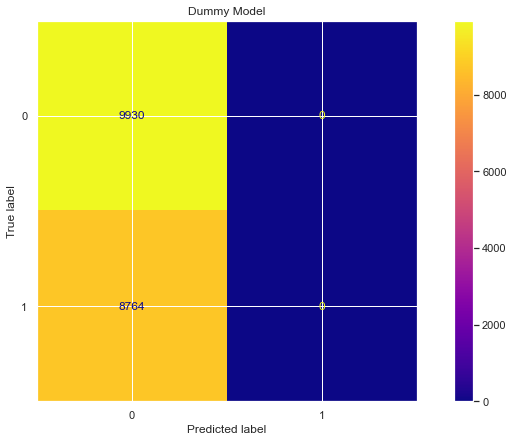

In [146]:
fig, ax = plt.subplots()

plt.title("Dummy Model")

plot_confusion_matrix(dummy_model, X_train_sc, y_train, ax=ax, cmap="plasma");

In [147]:
# just the numbers
confusion_matrix(y_train, dummy_model.predict(X_train_sc))

array([[9930,    0],
       [8764,    0]])

This is a pretty lopsided confusion matrix.

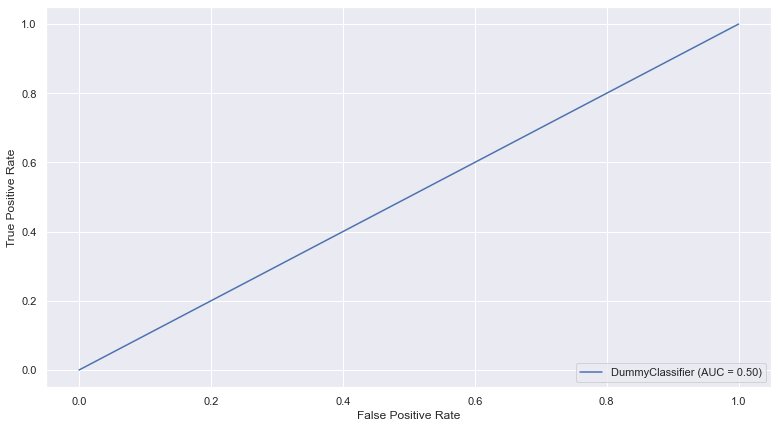

In [148]:
plot_roc_curve(dummy_model, X_train_sc, y_train);

The ROC value is very low, .5.

## Baseline Logistic Regression Model

Logistic Regression is a statistical method used for binary classification, which means predicting a binary outcome (0 or 1). It is widely used in machine learning for solving classification problems. Logistic Regression models the probability of a binary response based on one or more predictor variables. The goal of a logistic regression model is to find the best-fit relationship between the dependent variable (target variable) and independent variables (features), by estimating the probabilities using a logistic function or sigmoid curve. The output of the logistic regression model is a probability value between 0 and 1, which can be converted to a binary output using a threshold value.

In [149]:
# Initializing
lr_base = LogisticRegression()
lr_base = Pipeline(steps=[
    ('ss',StandardScaler()),
    ('knn',KNeighborsClassifier(n_neighbors=5, n_jobs=-1))
])

# Training
lr_base.fit(X_train_sc, y_train)

# Predicting
y_pred_lr_base = lr_base.predict(X_train_sc)


print(classification_report(y_train, y_pred_lr_base))
print(confusion_matrix(y_train, y_pred_lr_base))

# Getting accuracy and precision scores of train set
lr_base_acc = accuracy_score(y_train, y_pred_lr_base)
lr_base_prec = precision_score(y_train, y_pred_lr_base)
print()
print(f"The base Logistic Regression accuracy is: {lr_base_acc*100 :.2f}%.")
print(f"The base Logistic Regression precission is: {lr_base_prec*100 :.2f}%.")

              precision    recall  f1-score   support

           0       0.78      0.81      0.79      9930
           1       0.77      0.73      0.75      8764

    accuracy                           0.77     18694
   macro avg       0.77      0.77      0.77     18694
weighted avg       0.77      0.77      0.77     18694

[[8034 1896]
 [2326 6438]]

The base Logistic Regression accuracy is: 77.42%.
The base Logistic Regression precission is: 77.25%.


In [150]:
# Cross validation for calassification ives us accuracy by default
cv_lr_base = cross_validate(lr_base, X_train_sc, y_train, cv=5)

# Getting the mean accuracy score
lr_base_mean_acc = cv_lr_base['test_score'].mean()

# Printing the result
print(f"The mean cross validation accuracy of the base logistic regression model is {lr_base_mean_acc:.4f}.")

The mean cross validation accuracy of the base logistic regression model is 0.7724.


In [151]:
# Cross-validation
lr_base_cv_results = cross_val_score(lr_base, X_train_sc, y_train, cv=5, scoring='precision')

# Getting the mean precision score
lr_base_mean_precision = lr_base_cv_results.mean()

# Printing the result
print(f"The mean cross validation precision of the logistic regression model is: {lr_base_mean_precision:.4f}")

The mean cross validation precision of the logistic regression model is: 0.7710


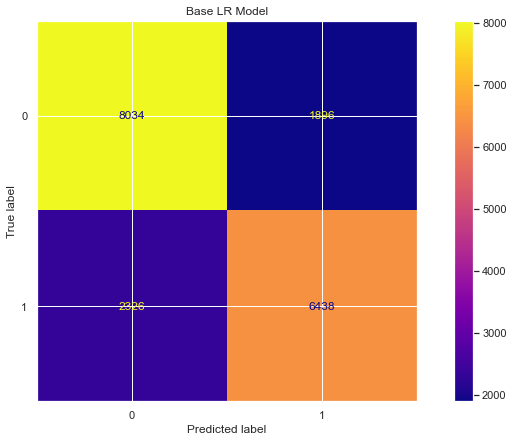

In [152]:
fig, ax = plt.subplots()

plt.title("Base LR Model")

plot_confusion_matrix(lr_base, X_train_sc, y_train, ax=ax, cmap="plasma");

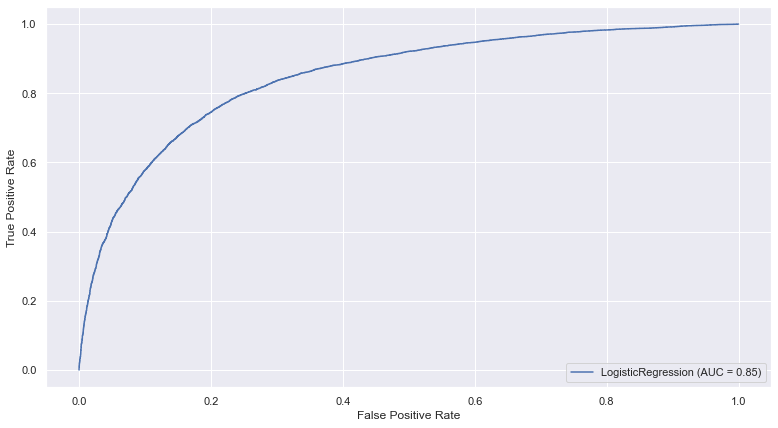

In [153]:
plot_roc_curve(lr_base, X_train_sc, y_train);

Much better looking confusion matrix as well as AUC compared to the dummy model.

## Baseline Decision Tree Model

Decision trees are a type of parametric model that recursively partitions the feature space into smaller and smaller regions based on the most informative features. The partitioning process stops when a stopping criterion is met, such as when all data points in a region belong to the same class or when a maximum depth is reached. Decision trees can work well when the decision boundary is nonlinear and can handle both continuous and categorical data. They are often used as standalone models or as part of an ensemble model, such as a random forest.

In [154]:
# Initializing
dt_base = DecisionTreeClassifier()

# Training
dt_base.fit(X_train_sc, y_train)

# Predicting
y_pred_dt_base = dt_base.predict(X_train_sc)


print(classification_report(y_train, y_pred_dt_base))
print(confusion_matrix(y_train, y_pred_dt_base))

# Getting accuracy and precision scores of train set
dt_base_acc = accuracy_score(y_train, y_pred_dt_base)
dt_base_prec = precision_score(y_train, y_pred_dt_base)
print()
print(f"The base Decision Tree Model accuracy is: {dt_base_acc*100 :.2f}%.")
print(f"The base Decision Tree Model precission is: {dt_base_prec*100 :.2f}%.")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9930
           1       1.00      1.00      1.00      8764

    accuracy                           1.00     18694
   macro avg       1.00      1.00      1.00     18694
weighted avg       1.00      1.00      1.00     18694

[[9930    0]
 [   0 8764]]

The base Decision Tree Model accuracy is: 100.00%.
The base Decision Tree Model precission is: 100.00%.


In [155]:
%%time
# Cross validation for calassification ives us accuracy by default
cv_dt_base = cross_validate(dt_base, X_train_sc, y_train, cv=5)

# Getting the mean accuracy score
dt_base_mean_acc = cv_dt_base['test_score'].mean()

# Printing the result
print(f"The mean cross validation accuracy of the base decision tree model is {dt_base_mean_acc:.4f}.")

The mean cross validation accuracy of the base decision tree model is 0.6810.
CPU times: user 791 ms, sys: 20.7 ms, total: 812 ms
Wall time: 844 ms


In [156]:
# Cross-validation
dt_base_cv_results = cross_val_score(dt_base, X_train_sc, y_train, cv=5, scoring='precision')

# Getting the mean precision score
dt_base_mean_precision = dt_base_cv_results.mean()

# Printing the result
print(f"The mean cross validation precision of the decision tree model is: {dt_base_mean_precision:.4f}")

The mean cross validation precision of the decision tree model is: 0.6591


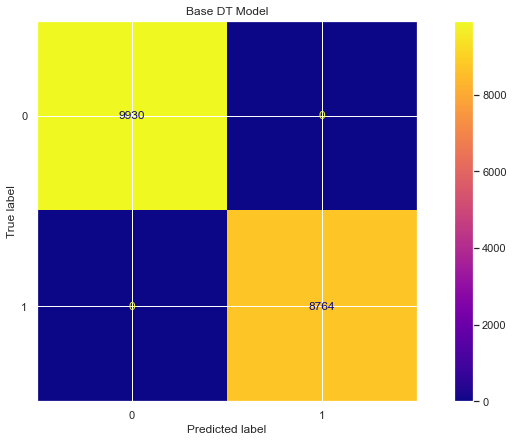

In [157]:
fig, ax = plt.subplots()

plt.title("Base DT Model")

plot_confusion_matrix(dt_base, X_train_sc, y_train, ax=ax, cmap="plasma");

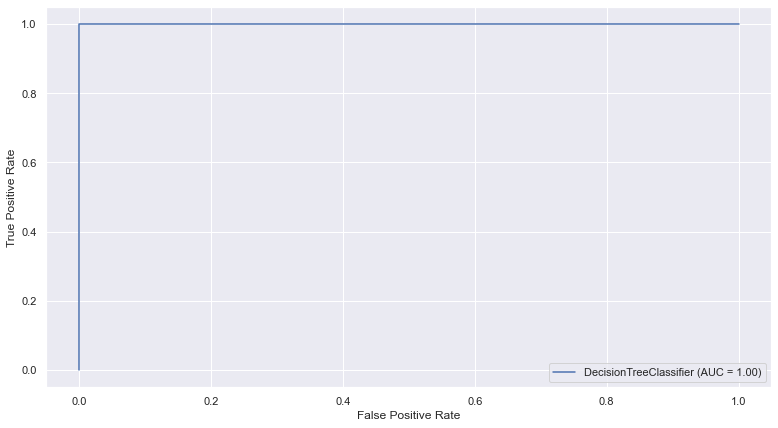

In [158]:
plot_roc_curve(dt_base, X_train_sc, y_train);

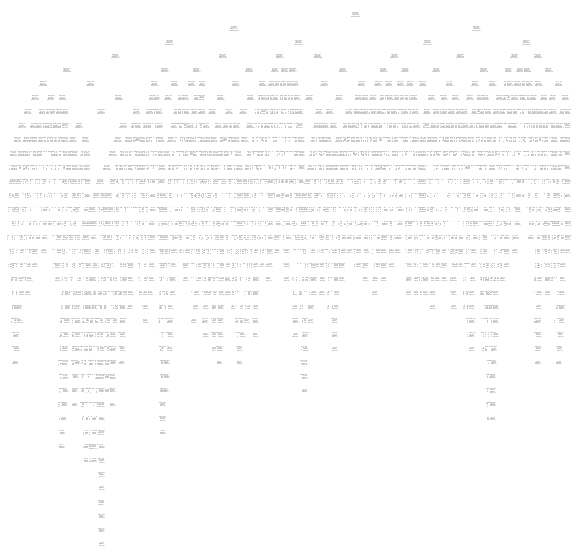

In [159]:
f, ax = plt.subplots(figsize=(10, 10))
plot_tree(dt_base, ax=ax);

A ROC score (AUC) of 1 means that the model is overfitting. 
This is probably due to there not being a max depth setting being set.

We can see that the 100% precision and accuracy score is misleading becasue when we cross validate, the precision and accuracy scores go down. This means the model was only perfect on the training dataset and when introduced to new datasets such as by cross validation, it does not do that well.

## Base KNN Model

KNN is a non-parametric and lazy learning algorithm, meaning that it does not make any assumptions about the underlying data distribution and it does not build a model during training. Instead, KNN stores all the training data in memory and predicts the label of a new data point based on the labels of its k nearest neighbors in the training data. The number of neighbors, k, is a hyperparameter that needs to be chosen based on the problem at hand. KNN can work well when the decision boundary is nonlinear

In [312]:
# Initializing
knn_base = KNeighborsClassifier()


# Training
knn_base.fit(X_train_sc, y_train)

# Predicting
y_pred_knn_base = knn_base.predict(X_train_sc)


print(classification_report(y_train, y_pred_knn_base))
print(confusion_matrix(y_train, y_pred_knn_base))

# Getting accuracy and precision scores of train set
knn_base_acc = accuracy_score(y_train, y_pred_knn_base)
knn_base_prec = precision_score(y_train, y_pred_knn_base)
print()
print(f"The base K nearest neighbors model accuracy is: {knn_base_acc*100 :.2f}%.")
print(f"The base K nearest neighbors model precission is: {knn_base_prec*100 :.2f}%.")

              precision    recall  f1-score   support

           0       0.79      0.83      0.81      9930
           1       0.80      0.75      0.77      8764

    accuracy                           0.79     18694
   macro avg       0.79      0.79      0.79     18694
weighted avg       0.79      0.79      0.79     18694

[[8272 1658]
 [2206 6558]]

The base K nearest neighbors model accuracy is: 79.33%.
The base K nearest neighbors model precission is: 79.82%.


In [183]:
# Cross validation for calassification ives us accuracy by default
cv_knn_base = cross_validate(knn_base, X_train_sc, y_train, cv=5)

# Getting the mean accuracy score
knn_base_mean_acc = cv_knn_base['test_score'].mean()

# Printing the result
print(f"The mean cross validation accuracy of the base K nearest neighbors model is {knn_base_mean_acc:.4f}.")

The mean cross validation accuracy of the base K nearest neighbors model is 0.6841.


In [162]:
# Cross-validation
knn_base_cv_results = cross_val_score(knn_base, X_train_sc, y_train, cv=5, scoring='precision')

# Getting the mean precision score
knn_base_mean_precision = knn_base_cv_results.mean()

# Printing the result
print(f"The mean cross validation precision of the base K nearest neighbors model is: {knn_base_mean_precision:.4f}")

The mean cross validation precision of the base K nearest neighbors model is: 0.6740


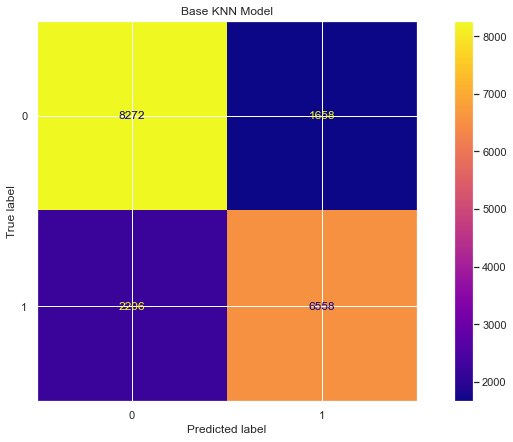

In [163]:
fig, ax = plt.subplots()

plt.title("Base KNN Model")

plot_confusion_matrix(knn_base, X_train_sc, y_train, ax=ax, cmap="plasma");

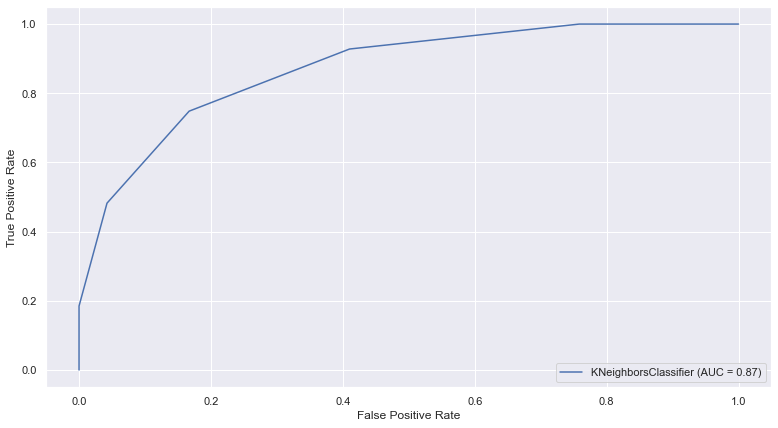

In [164]:
plot_roc_curve(knn_base, X_train_sc, y_train);

## Base Naive Bayes Model

In [165]:
# Initializing
gnb_base = GaussianNB()

# Training
gnb_base.fit(X_train_sc, y_train)

# Predicting
y_pred_gnb_base = gnb_base.predict(X_train_sc)


print(classification_report(y_train, y_pred_gnb_base))
print(confusion_matrix(y_train, y_pred_gnb_base))

# Getting accuracy and precision scores of train set
gnb_base_acc = accuracy_score(y_train, y_pred_gnb_base)
gnb_base_prec = precision_score(y_train, y_pred_gnb_base)
print()
print(f"The base naive bayes model accuracy is: {gnb_base_acc*100 :.2f}%.")
print(f"The base naive bayes model precission is: {gnb_base_prec*100 :.2f}%.")

              precision    recall  f1-score   support

           0       0.75      0.68      0.71      9930
           1       0.67      0.75      0.71      8764

    accuracy                           0.71     18694
   macro avg       0.71      0.71      0.71     18694
weighted avg       0.71      0.71      0.71     18694

[[6704 3226]
 [2210 6554]]

The base naive bayes model accuracy is: 70.92%.
The base naive bayes model precission is: 67.01%.


In [166]:
# Cross validation for calassification ives us accuracy by default
cv_gnb_base = cross_validate(gnb_base, X_train_sc, y_train, cv=5)

# Getting the mean accuracy score
gnb_base_mean_acc = cv_gnb_base['test_score'].mean()

# Printing the result
print(f"The mean cross validation accuracy of the base naive bayes model is {gnb_base_mean_acc:.4f}.")

The mean cross validation accuracy of the base naive bayes model is 0.7088.


In [167]:
# Cross-validation
gnb_base_cv_results = cross_val_score(gnb_base, X_train_sc, y_train, cv=5, scoring='precision')

# Getting the mean precision score
gnb_base_mean_precision = gnb_base_cv_results.mean()

# Printing the result
print(f"The mean cross validation precision of the base naive bayes model is: {gnb_base_mean_precision:.4f}")

The mean cross validation precision of the base naive bayes model is: 0.6698


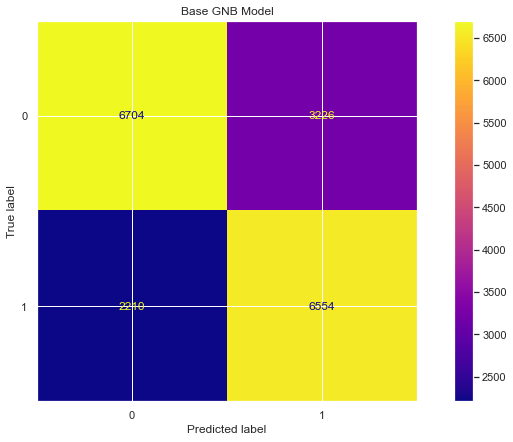

In [168]:
fig, ax = plt.subplots()

plt.title("Base GNB Model")

plot_confusion_matrix(gnb_base, X_train_sc, y_train, ax=ax, cmap="plasma");

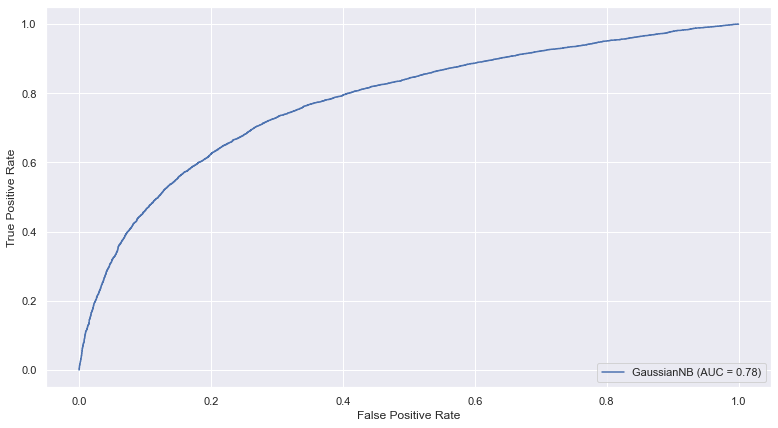

In [169]:
plot_roc_curve(gnb_base, X_train_sc, y_train);

## Base Random Forest

A random forest model is a type of ensemble learning algorithm that uses multiple decision trees to make predictions. In a random forest model, each decision tree is built independently, using a randomly selected subset of the training data and a random subset of the available features at each split. This randomization helps to reduce overfitting and improve the accuracy of the model. The final prediction is made by combining the predictions of all the individual trees in the forest.

In [225]:
from sklearn.ensemble import RandomForestClassifier

base_rf_pipeline = Pipeline(steps=[
    ('ss',StandardScaler()),
    ('rfc',RandomForestClassifier(random_state=1,
                max_depth=5, n_jobs=-2))
])

In [227]:
base_rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('rfc',
                 RandomForestClassifier(max_depth=5, n_jobs=-2,
                                        random_state=1))])

In [234]:
# Initializing
rf_base = RandomForestClassifier()

# Training
rf_base.fit(X_train_sc, y_train)

# Predicting
y_pred_rf_base = rf_base.predict(X_train)


print(classification_report(y_train, y_pred_rf_base))
print(confusion_matrix(y_train, y_pred_rf_base))

# Getting accuracy and precision scores of train set
rf_base_acc = accuracy_score(y_train, y_pred_rf_base)
rf_base_prec = precision_score(y_train, y_pred_rf_base)
print()
print(f"The base random forest model accuracy is: {rf_base_acc*100 :.2f}%.")
print(f"The base random forest model precission is: {rf_base_prec*100 :.2f}%.")

              precision    recall  f1-score   support

           0       0.94      0.01      0.01      9930
           1       0.47      1.00      0.64      8764

    accuracy                           0.47     18694
   macro avg       0.70      0.50      0.33     18694
weighted avg       0.72      0.47      0.31     18694

[[  75 9855]
 [   5 8759]]

The base random forest model accuracy is: 47.26%.
The base random forest model precission is: 47.06%.


In [235]:
# Cross validation for calassification ives us accuracy by default
cv_rf_base = cross_validate(rf_base, X_train_sc, y_train, cv=5)

# Getting the mean accuracy score
rf_base_mean_acc = cv_rf_base['test_score'].mean()

# Printing the result
print(f"The mean cross validation accuracy of the base random forest model is {rf_base_mean_acc:.4f}.")

The mean cross validation accuracy of the base random forest model is 0.7686.


In [236]:
# Cross-validation
rf_base_cv_results = cross_val_score(rf_base, X_train_sc, y_train, cv=5, scoring='precision')

# Getting the mean precision score
rf_base_mean_precision = rf_base_cv_results.mean()

# Printing the result
print(f"The mean cross validation precision of the base random forest model is: {rf_base_mean_precision:.4f}")

The mean cross validation precision of the base random forest model is: 0.7686


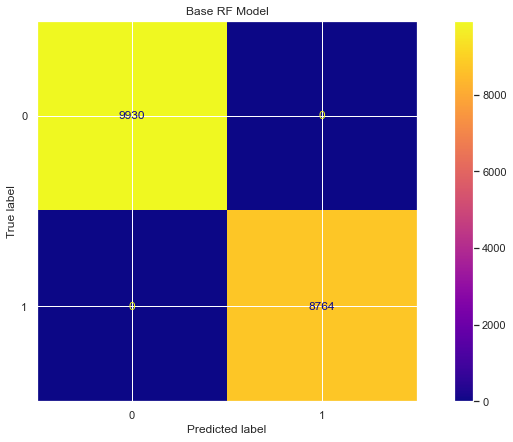

In [244]:
fig, ax = plt.subplots()

plt.title("Base RF Model")

plot_confusion_matrix(rf_base, X_train_sc, y_train, ax=ax, cmap="plasma");

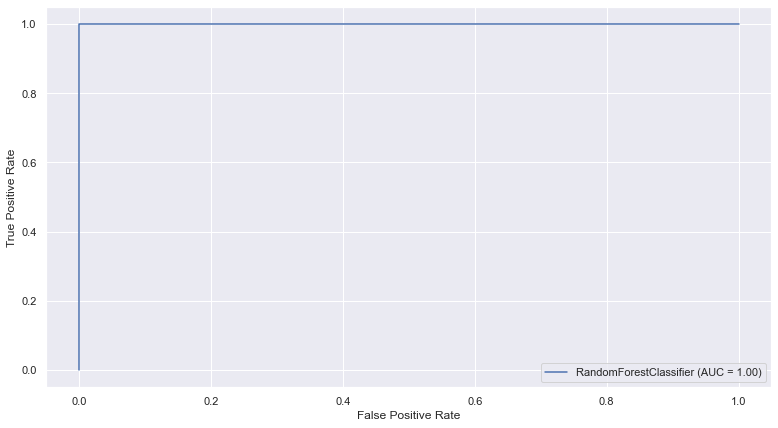

In [295]:
plot_roc_curve(rf_base, X_train_sc, y_train);

The base random forest model is very overfit as we can see from the ROC score. The cv precision score is pretty high however and would be worth looking into.

# Model comparison

In [237]:
accuracy_score = [dummy_acc, lr_base_mean_acc, dt_base_mean_acc, knn_base_mean_acc, 
                  gnb_base_mean_acc, rf_base_mean_acc]
mean_precision_score = [dummy_mean_precision, lr_base_mean_precision, dt_base_mean_precision,
                    knn_base_mean_precision, gnb_base_mean_precision, rf_base_mean_precision]
Models = ['Dummy Model', 'Base Logistic Regression', 'Base Decission Tree', 
          'Base KNearest Neighbors', 'Base Gaussian NB', 'Base Random Forest']

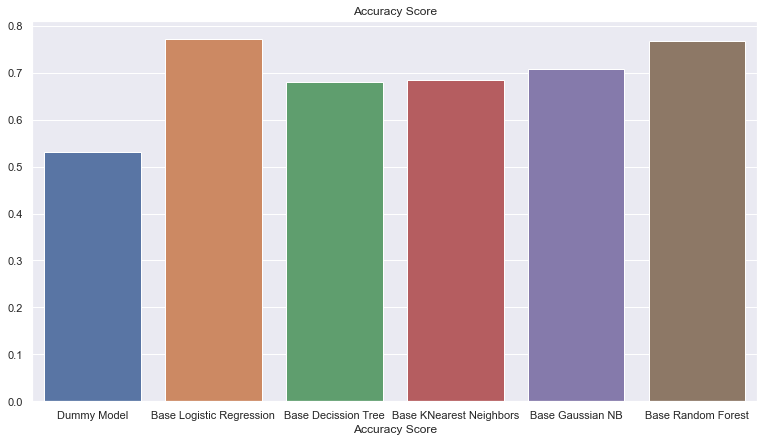

In [238]:
sns.barplot(x=Models, y=accuracy_score)
plt.xlabel('Accuracy Score')
plt.title('Accuracy Score')
plt.show()

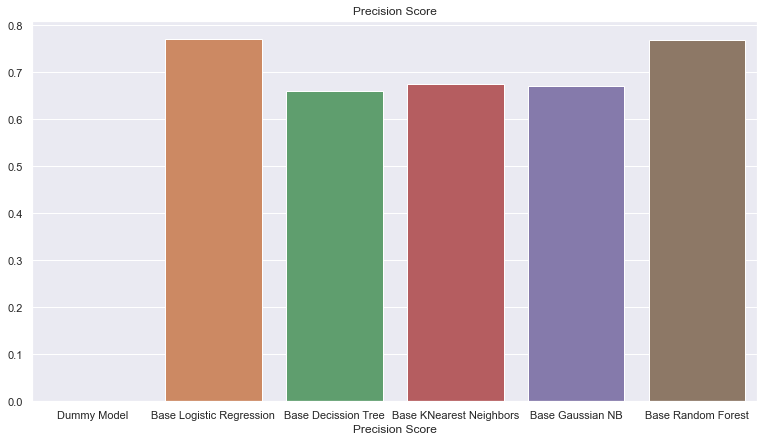

In [239]:
sns.barplot(x=Models, y=mean_precision_score)
plt.xlabel('Precision Score')
plt.title('Precision Score')
plt.show()

Since both the accuracy and precision score for the cross validation for the base random forest model were the highest, I will choose this model to iterate over for my final model.

# Hyperperameters

## Logistic Regression Grid Search

In [190]:
LogisticRegression().get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

We are searching over different values of the regularization parameter C and the penalty type (l1 and l2) using logistic regression. We are using precision as the scoring metric for grid search since we want to decrease the amount of false positives.

In [219]:
%%time

# logistic regression regressor
lr_1 = LogisticRegression()

# defining the hyperparameters to search over
# defalut for penalty is 12, solver is ibfgs, and C is 1
param_grid = {'penalty': ['l1', 'l2', 'elasticnet', 'none'],
              'C': [0.01, 0.1, 1, 10, 100], 
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
             }

# define the grid search object
grid_lr_1 = GridSearchCV(lr_1, param_grid, scoring='precision', cv=5)

# fit the grid search object to the training data
grid_lr_1.fit(X_train_sc, y_train)

/Users/alisonpark/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/alisonpark/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/alisonpark/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/alisonpark/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warn

/Users/alisonpark/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/alisonpark/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/alisonpark/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/alisonpark/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/alisonpark/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will igno

/Users/alisonpark/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/alisonpark/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/alisonpark/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/alisonpark/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.

/Users/alisonpark/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/alisonpark/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/alisonpark/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/alisonpark/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/alisonpark/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will igno

/Users/alisonpark/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/alisonpark/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/alisonpark/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/alisonpark/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 453, in _check_solver
    raise ValueError(
ValueError: penalty='none' is not supported for the liblinear solver

  warnings.warn("Estimator fit failed. The score on this train-test"
/User

/Users/alisonpark/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/alisonpark/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/alisonpark/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/alisonpark/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/alisonpark/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will igno

/Users/alisonpark/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/alisonpark/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/alisonpark/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/alisonpark/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/alisonpark/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will igno

CPU times: user 1min 45s, sys: 5.53 s, total: 1min 50s
Wall time: 1min 24s


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='precision')

In [ ]:
"""
pipeline but idk why it doesn't work. try again later
"""

# Create pipeline
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic', LogisticRegression())
])

# Define hyperparameters to search over
hyperparameters = {
    'logistic__penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'logistic__C': [0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

# Create GridSearchCV object
lr_gridsearch = GridSearchCV(lr_pipeline, hyperparameters, scoring='precision', cv=5)

# Fit the GridSearchCV object to the training data
lr_gridsearch.fit(X_train, y_train)

In [ ]:
# Print the best hyperparameters and precision score
print('Best penalty:', lr_gridsearch.best_estimator_.get_params()['logistic__penalty'])
print('Best C:', lr_gridsearch.best_estimator_.get_params()['logistic__C'])
print('Best precision:', lr_gridsearch.best_score_)
print(f"Base lr model precision score: {lr_base_mean_precision}")

The best_params_ attribute of the grid search object will give you the hyperparameters that resulted in the best precision score, and the best_score_ attribute will give you the precision score itself.

In [220]:
# get the best parameters and score
print(f"Best parameters: {grid_lr_1.best_params_}")
print()
print(f"Base lr model precision score: {lr_base_mean_precision}")
print(f"Best precision score for lr_1: {grid_lr_1.best_score_}")

Best parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}

Base lr model precision score: 0.7710253385248613
Best precision score for lr_1: 0.7720352777673627


In [273]:
"""
Checking cross val precision score.
"""

lr_1_best = LogisticRegression(C=10, max_iter=1000, n_jobs=-1)
lr_1_best.fit(X_train_sc, y_train)

# Cross-validation
lr_1_cv_results = cross_val_score(lr_1_best, X_train_sc, y_train, cv=5, scoring='precision')

# Getting the mean precision score
lr_1_mean_precision = lr_1_cv_results.mean()

# Printing the result
print(f"The mean cross validation precision of the final logisitc regression model is: {lr_1_mean_precision:.4f}")

The mean cross validation precision of the base random forest model is: 0.7711


It seems like the precision score increases a little bit but not by much. Will search other perameters to see if the precision score goes up.

In [221]:
%%time

# best hyperparameters for logistic regression
best_params = grid_lr_1.best_params_

# creating a new logistic regression object with best hyperparameters from grid_lr_1
lr_2 = LogisticRegression(**best_params)

# define new parameters grid
param_grid_2 = {'class_weight': [None, 'balanced'], 
              'tol': [1e-4, 1e-5, 1e-6], 
              'max_iter': [100, 500, 1000, 10000, 50000]
               }

# define the grid search object
grid_lr_2 = GridSearchCV(estimator=lr_2, param_grid=param_grid_2, scoring='precision', cv=5)

CPU times: user 99 µs, sys: 216 µs, total: 315 µs
Wall time: 321 µs


In [222]:
%%time

# fit the grid search object to the training data with best hyperparameters fixed
grid_lr_2.fit(X_train_sc, y_train)

/Users/alisonpark/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/alisonpark/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/alisonpark/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/alisonpark/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Use

CPU times: user 2min 44s, sys: 3.91 s, total: 2min 48s
Wall time: 2min 40s


GridSearchCV(cv=5,
             estimator=LogisticRegression(C=0.1, penalty='l1', solver='saga'),
             param_grid={'class_weight': [None, 'balanced'],
                         'max_iter': [100, 500, 1000, 10000, 50000],
                         'tol': [0.0001, 1e-05, 1e-06]},
             scoring='precision')

In [240]:
# get the best parameters and score
print(f"Best parameters: {grid_lr_2.best_params_}")
print()
print(f"Base lr model precision score: {lr_base_mean_precision}")
print(f"Best precision score for lr_1: {grid_lr_1.best_score_}")
print(f"Best precision score for lr_2: {grid_lr_2.best_score_}")

Best parameters: {'class_weight': None, 'max_iter': 100, 'tol': 0.0001}

Base lr model precision score: 0.7710253385248613
Best precision score for lr_1: 0.7720352777673627
Best precision score for lr_2: 0.7720352777673627


In [241]:
%%time

# best hyperparameters for logistic regression
best_params = {'C': 0.01, 'penalty': 'l1', 'max_iter': 100, 'solver': 'saga'}

# creating a new logistic regression object with best hyperparameters from grid_lr_1
lr_3 = LogisticRegression(**best_params)

# define new parameters grid
param_grid_3 = {'tol': [1e-4, 1e-5, 1e-6], 
                'n_jobs': [-1, 1, 2, 4],
               }

# define the grid search object
grid_lr_3 = GridSearchCV(estimator=lr_3, param_grid=param_grid_3, scoring='precision', cv=5)

CPU times: user 59 µs, sys: 8 µs, total: 67 µs
Wall time: 82 µs


In [242]:
%%time

# fit the grid search object to the training data with best hyperparameters fixed
grid_lr_3.fit(X_train_sc, y_train)

CPU times: user 9.99 s, sys: 1.41 s, total: 11.4 s
Wall time: 40.4 s


GridSearchCV(cv=5,
             estimator=LogisticRegression(C=0.01, penalty='l1', solver='saga'),
             param_grid={'n_jobs': [-1, 1, 2, 4],
                         'tol': [0.0001, 1e-05, 1e-06]},
             scoring='precision')

In [243]:
# get the best parameters and score
print(f"Best parameters: {grid_lr_3.best_params_}")
print()
print(f"Base lr model precision score: {lr_base_mean_precision}")
print(f"Best precision score for lr_1: {grid_lr_1.best_score_}")
print(f"Best precision score for lr_2: {grid_lr_2.best_score_}")
print(f"Best precision score for lr_3: {grid_lr_3.best_score_}")

Best parameters: {'n_jobs': -1, 'tol': 0.0001}

Base lr model precision score: 0.7710253385248613
Best precision score for lr_1: 0.7720352777673627
Best precision score for lr_2: 0.7720352777673627
Best precision score for lr_3: 0.7688170462168689


In [207]:
%%time

# best hyperparameters for logistic regression
best_params = {'C': 0.01, 'penalty': 'l1', 'max_iter': 100, 'solver': 'saga'}

# creating a new logistic regression object with best hyperparameters from grid_lr_1
lr_4 = LogisticRegression(**best_params)

# define new parameters grid
param_grid_4 = {'multi_class': ['auto', 'ovr', 'multinomial'], 
                'verbose': [0, 1, 2],
               }

# define the grid search object
grid_lr_4 = GridSearchCV(estimator=lr_4, param_grid=param_grid_4, scoring='precision', cv=5)

CPU times: user 60 µs, sys: 1 µs, total: 61 µs
Wall time: 65.1 µs


In [208]:
%%time

# fit the grid search object to the training data with best hyperparameters fixed
grid_lr_4.fit(X_train_sc, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 16 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 17 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 18 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 16 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 16 epochs took 1 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 17 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 16 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 18 epochs took 1 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 18 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 17 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 16 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 16 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 18 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 16 epochs took 1 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 17 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 16 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 17 epochs took 1 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 17 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 18 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 16 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 19 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 19 epochs took 1 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 19 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 21 epochs took 1 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 20 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 18 epochs took 1 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 20 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 19 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 19 epochs took 1 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 18 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished


CPU times: user 19.2 s, sys: 1.01 s, total: 20.2 s
Wall time: 16.1 s


GridSearchCV(cv=5,
             estimator=LogisticRegression(C=0.01, penalty='l1', solver='saga'),
             param_grid={'multi_class': ['auto', 'ovr', 'multinomial'],
                         'verbose': [0, 1, 2]},
             scoring='precision')

In [210]:
# get the best parameters and score
print(f"Best parameters: {grid_lr_4.best_params_}")
print()
print(f"Base lr model precision score: {lr_base_mean_precision}")
print(f"Best precision score for lr_1: {grid_lr_1.best_score_}")
print(f"Best precision score for lr_2: {grid_lr_2.best_score_}")
print(f"Best precision score for lr_3: {grid_lr_3.best_score_}")
print(f"Best precision score for lr_4: {grid_lr_4.best_score_}")

Best parameters: {'multi_class': 'auto', 'verbose': 0}

Base lr model precision score: 0.7710253385248613
Best precision score for lr_1: 0.7720352777673627
Best precision score for lr_2: 0.7720352777673627
Best precision score for lr_3: 0.7688170462168689
Best precision score for lr_4: 0.7688461455589127


In [ ]:
"""
Back to starting with lr_1 becasue that had the best precision
"""

%%time

# best hyperparameters for logistic regression
best_params = grid_lr_1.best_params_

# creating a new logistic regression object with best hyperparameters from grid_lr_1
lr_5 = LogisticRegression(**best_params)

# define new parameters grid
param_grid_5 = {'class_weight': [None, 'balanced'],
               }

# define the grid search object
grid_lr_5 = GridSearchCV(estimator=lr_5, param_grid=param_grid_5, scoring='precision', cv=5)

## Random forest model grid search

### First grid search

In [278]:
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier())
])

In [279]:
rf_param_grid = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [5, 10, 20, None],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['auto', 'sqrt', 'log2']
}

In [282]:
rf_grid = GridSearchCV(rf_pipeline, rf_param_grid, cv=5, n_jobs=-1, verbose=2, scoring='precision')

In [283]:
rf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 18.7min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed: 21.4min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [5, 10, 20, None],
                         'rf__max_features': ['auto', 'sqrt', 'log2'],
                         'rf__min_samples_leaf': [1, 2, 4],
                         'rf__min_samples_split': [2, 5, 10],
                         'rf__n_estimators': [50, 100, 200]},
             scoring='precision', verbose=2)

In [285]:
print("Best parameters: ", rf_grid.best_params_)
print("Best score: ", rf_grid.best_score_)

Best parameters:  {'rf__max_depth': 5, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}
Best score:  0.7816936136193418


In [327]:
rf_1_model = RandomForestClassifier(max_depth= 5, max_features='log2', 
                                    min_samples_leaf= 1, min_samples_split=2, 
                                    n_estimators=100)
rf_1_model.fit(X_train_sc, y_train)

# Compute precision score using cross-validation
cv_precision_scores = cross_val_score(rf_1_model, X_train_sc, y_train, cv=5, scoring='precision')

# Compute mean and standard deviation of precision scores
mean_precision_score = cv_precision_scores.mean()

# Print mean of precision scores
print(f"The mean cross validation precision of the first random forest model is: {mean_precision_score:.4f}")

The mean cross validation precision of the first random forest model is: 0.7791


### Second grid search

In [303]:
rf_pipeline_2 = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(max_features='log2', 
                                  min_samples_leaf=1, min_samples_split=2,))
])

In [305]:
RandomForestClassifier()
rf_param_grid_2 = {
    'rf__n_estimators': [50, 100, 200, 300],
    'rf__max_depth': [5, 10, 20, 30, None],
    'rf__class_weight': ["balanced", None],
}

In [306]:
rf_grid_2 = GridSearchCV(rf_pipeline_2, rf_param_grid_2, cv=5, n_jobs=-1, verbose=2, scoring='precision')

In [307]:
rf_grid_2.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  4.6min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('rf',
                                        RandomForestClassifier(max_features='log2'))]),
             n_jobs=-1,
             param_grid={'rf__class_weight': ['balanced', None],
                         'rf__max_depth': [5, 10, 20, 30, None],
                         'rf__n_estimators': [50, 100, 200, 300]},
             scoring='precision', verbose=2)

In [309]:
print("Best parameters: ", rf_grid_2.best_params_)
print("Best score: ", rf_grid_2.best_score_)

Best parameters:  {'rf__class_weight': None, 'rf__max_depth': 5, 'rf__n_estimators': 50}
Best score:  0.779466219740222


In [310]:
rf_2_model = RandomForestClassifier(max_depth= 5, max_features='log2', 
                                    min_samples_leaf= 1, min_samples_split=2, 
                                    n_estimators=50, class_weight=None)
rf_2_model.fit(X_train_sc, y_train)

# Compute precision score using cross-validation
cv_precision_scores = cross_val_score(rf_2_model, X_train_sc, y_train, cv=5, scoring='precision')

# Compute mean and standard deviation of precision scores
mean_precision_score = cv_precision_scores.mean()

# Print mean of precision scores
print(f"The mean cross validation precision of the second random forest model is: {mean_precision_score:.4f}")

The mean cross validation precision of the final random forest model is: 0.7739


### Third grid search

In [316]:
rf_pipeline_3 = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(max_features='log2', max_depth=5,
                                  min_samples_leaf=1, min_samples_split=2,))
])

In [317]:
RandomForestClassifier()
rf_param_grid_3 = {
    'rf__n_estimators': [30, 50, 100, 200, 250, 300],
    'rf__criterion': ["gini", "entropy"]
}

In [318]:
rf_grid_3 = GridSearchCV(rf_pipeline_3, rf_param_grid_3, cv=5, n_jobs=-1, verbose=2, scoring='precision')

In [322]:
rf_grid_3.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   27.3s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('rf',
                                        RandomForestClassifier(max_depth=5,
                                                               max_features='log2'))]),
             n_jobs=-1,
             param_grid={'rf__criterion': ['gini', 'entropy'],
                         'rf__n_estimators': [30, 50, 100, 200, 250, 300]},
             scoring='precision', verbose=2)

In [323]:
print("Best parameters: ", rf_grid_3.best_params_)
print("Best score: ", rf_grid_3.best_score_)

Best parameters:  {'rf__criterion': 'entropy', 'rf__n_estimators': 250}
Best score:  0.7824490391929667


In [326]:
rf_3_model = RandomForestClassifier(max_depth= 5, max_features='log2', 
                                    min_samples_leaf= 1, min_samples_split=2, 
                                    n_estimators=250, class_weight=None, 
                                    criterion='entropy'
                                   )
rf_3_model.fit(X_train_sc, y_train)

# Compute precision score using cross-validation
cv_precision_scores = cross_val_score(rf_3_model, X_train_sc, y_train, cv=5, scoring='precision')

# Compute mean and standard deviation of precision scores
mean_precision_score = cv_precision_scores.mean()

# Print mean of precision scores
print(f"The mean cross validation precision of the third random forest model is: {mean_precision_score:.4f}")

The mean cross validation precision of the third random forest model is: 0.7784


### Fourth grid search

In [328]:
rf_pipeline_4 = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(max_depth= 5, max_features='log2', 
                                  min_samples_leaf= 1, min_samples_split=2, 
                                  n_estimators=100))
])

In [329]:
RandomForestClassifier()
rf_param_grid_4 = {
    'rf__criterion': ["gini", "entropy"]
}

In [332]:
rf_grid_4 = GridSearchCV(rf_pipeline_4, rf_param_grid_4, cv=10, n_jobs=-1, verbose=2, scoring='precision')

In [333]:
rf_grid_4.fit(X_train, y_train)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    7.0s finished


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('rf',
                                        RandomForestClassifier(max_depth=5,
                                                               max_features='log2'))]),
             n_jobs=-1, param_grid={'rf__criterion': ['gini', 'entropy']},
             scoring='precision', verbose=2)

In [334]:
print("Best parameters: ", rf_grid_4.best_params_)
print("Best score: ", rf_grid_4.best_score_)

Best parameters:  {'rf__criterion': 'entropy'}
Best score:  0.7790698631392386


In [336]:
rf_4_model = RandomForestClassifier(max_depth= 5, max_features='log2', 
                                    min_samples_leaf= 1, min_samples_split=2, 
                                    n_estimators=100, criterion='entropy'
                                   )
rf_4_model.fit(X_train_sc, y_train)

# Compute precision score using cross-validation
cv_precision_scores = cross_val_score(rf_4_model, X_train_sc, y_train, cv=5, scoring='precision')

# Compute mean and standard deviation of precision scores
mean_precision_score = cv_precision_scores.mean()

# Print mean of precision scores
print(f"The mean cross validation precision of the fourth random forest model is: {mean_precision_score:.4f}")

The mean cross validation precision of the fourth random forest model is: 0.7799


### Fifth grid search

The max_samples parameter in the RandomForestClassifier controls the maximum number of samples that can be used to train each tree in the forest. It can take values between 0 and 1, where 1 means all the samples will be used for training.
- 0.3: This means that each tree will be trained on a random sample of 30% of the data. This can be a good option for large datasets with many noisy or irrelevant features.

For the min_samples_leaf parameter in a random forest model, some good options for grid searching would be [1, 2, 4, 8, 16]. This range allows for exploring the trade-off between model complexity and generalization, as increasing the value of min_samples_leaf can prevent overfitting but also decrease the model's ability to capture complex relationships in the data.

The random state parameter is used to control the randomness of the algorithm, and setting it to a fixed value ensures that the results are reproducible. By grid searching over a range of values, you can try different random seeds to see if it affects the performance of the model.

In [340]:
rf_pipeline_5 = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(max_depth= 5, min_samples_split=2, 
                                  n_estimators=100, criterion='entropy'))
])

In [357]:
rf_param_grid_5 = {
    'rf__max_samples': [0.3, 0.5, 0.7, 1],
    'rf__min_samples_leaf': [1, 2, 4, 8, 16],
    'rf__random_state': range(0, 101)
}

In [358]:
rf_grid_5 = GridSearchCV(rf_pipeline_5, rf_param_grid_5, cv=10, n_jobs=-1, verbose=2, scoring='precision')

In [359]:
rf_grid_5.fit(X_train, y_train)

Fitting 10 folds for each of 2020 candidates, totalling 20200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   46.5s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 16.9min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 20.4min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed: 25.4min
[Parallel(n_jobs=-1)]: Done 6837 tasks      | elapsed: 30.4min
[Parallel(n_jobs=-1)]: Done 7930 tasks      | elapsed: 35.7min
[Parallel(n_jobs=-1)]: Done 9105 tasks      | 

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('rf',
                                        RandomForestClassifier(criterion='entropy',
                                                               max_depth=5))]),
             n_jobs=-1,
             param_grid={'rf__max_samples': [0.3, 0.5, 0.7, 1],
                         'rf__min_samples_leaf': [1, 2, 4, 8, 16],
                         'rf__random_state': range(0, 101)},
             scoring='precision', verbose=2)

In [360]:
print("Best parameters: ", rf_grid_5.best_params_)
print("Best score: ", rf_grid_5.best_score_)

Best parameters:  {'rf__max_samples': 0.3, 'rf__min_samples_leaf': 1, 'rf__random_state': 83}
Best score:  0.7825358387172757


In [361]:
rf_5_model = RandomForestClassifier(max_depth= 5, min_samples_split=2, 
                                    n_estimators=100, criterion='entropy', 
                                    max_samples=0.3, min_samples_leaf=1,
                                    max_features='log2', random_state=83
                                   )
rf_5_model.fit(X_train_sc, y_train)

# Compute precision score using cross-validation
cv_precision_scores = cross_val_score(rf_5_model, X_train_sc, y_train, cv=5, scoring='precision')

# Compute mean and standard deviation of precision scores
mean_precision_score = cv_precision_scores.mean()

# Print mean of precision scores
print(f"The mean cross validation precision of the fifth random forest model is: {mean_precision_score:.4f}")

The mean cross validation precision of the fifth random forest model is: 0.7807


# Final Model (Random Forest)

We ended up with our best final random forest model after the fifth iteration. The cross validation precison score was 0.7807 compared to the base rf model which was 0.7686.

In [363]:
# Define your Random Forest model with best hyperparameters
rf_final_model = RandomForestClassifier(max_depth= 5, min_samples_split=2, 
                                        n_estimators=100, criterion='entropy', 
                                        max_samples=0.3, min_samples_leaf=1,
                                        max_features='log2', random_state=83)
# Fit the model to train scaled
rf_final_model.fit(X_train_sc, y_train)

# Compute precision score using cross-validation
cv_precision_scores_final = cross_val_score(rf_final_model, X_train_sc, y_train, cv=5, scoring='precision')

# Compute mean and standard deviation of precision scores
mean_precision_score_final = cv_precision_scores_final.mean()

# Print mean of precision scores
print(f"The mean cross validation precision of the final random forest model is: {mean_precision_score_final:.4f}")


The mean cross validation precision of the final random forest model is: 0.7807


In [288]:
print(f"The mean cross validation precision of the base random forest model is: {rf_base_mean_precision:.4f}")

The mean cross validation precision of the base random forest model is: 0.7686


In [395]:
# Cross validation for calassification ives us accuracy by default
cv_rf_final = cross_validate(rf_final_model, X_train_sc, y_train, cv=5)

# Getting the mean accuracy score
rf_final_mean_acc = cv_rf_final['test_score'].mean()

# Printing the result
print(f"The mean cross validation accuracy of the base random forest model is {rf_final_mean_acc:.4f}.")

The mean cross validation accuracy of the base random forest model is 0.7623.


### Comparing the base rf model to the final rf model

In [364]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predicting the target variable for the testing data
y_pred_rf_final = rf_final_model.predict(X_test_sc)

# Evaluating the performance of the model on the testing data
accuracy = accuracy_score(y_test, y_pred_rf_final)
precision = precision_score(y_test, y_pred_rf_final)
recall = recall_score(y_test, y_pred_rf_final)
f1 = f1_score(y_test, y_pred_rf_final)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 score: {f1:.4f}")

Accuracy: 0.7706
Precision: 0.7898
Recall: 0.6805
F1 score: 0.7311


In [293]:
# Predicting the target variable for the testing data
y_pred_rf_base = rf_base.predict(X_test_sc)

# Evaluating the performance of the model on the testing data
accuracy = accuracy_score(y_test, y_pred_rf_base)
precision = precision_score(y_test, y_pred_rf_base)
recall = recall_score(y_test, y_pred_rf_base)
f1 = f1_score(y_test, y_pred_rf_base)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 score: {f1:.4f}")

Accuracy: 0.7796
Precision: 0.7701
Recall: 0.7399
F1 score: 0.7547


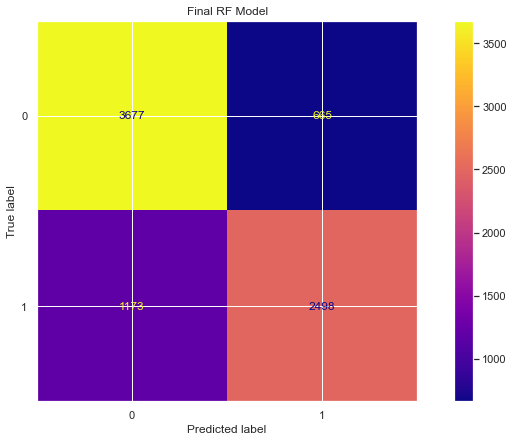

In [365]:
"""
Confusion matrix for the final model using testing data
"""

fig, ax = plt.subplots()

plt.title("Final RF Model")

plot_confusion_matrix(rf_final_model, X_test_sc, y_test, ax=ax, cmap="plasma");

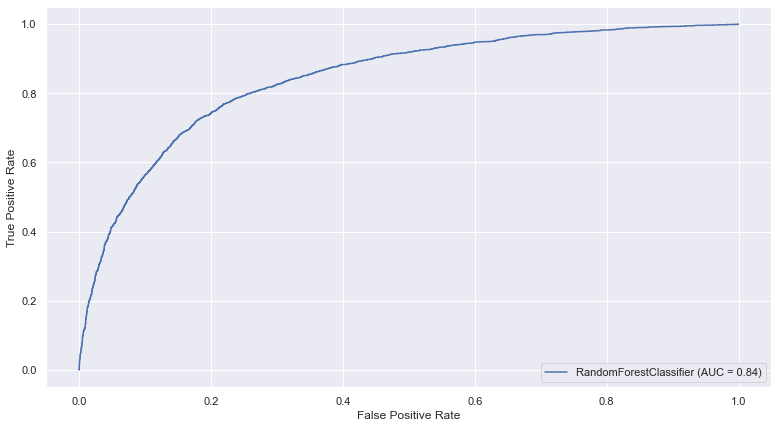

In [367]:
plot_roc_curve(rf_final_model, X_test_sc, y_test);

## Dummy vs Final Model

''

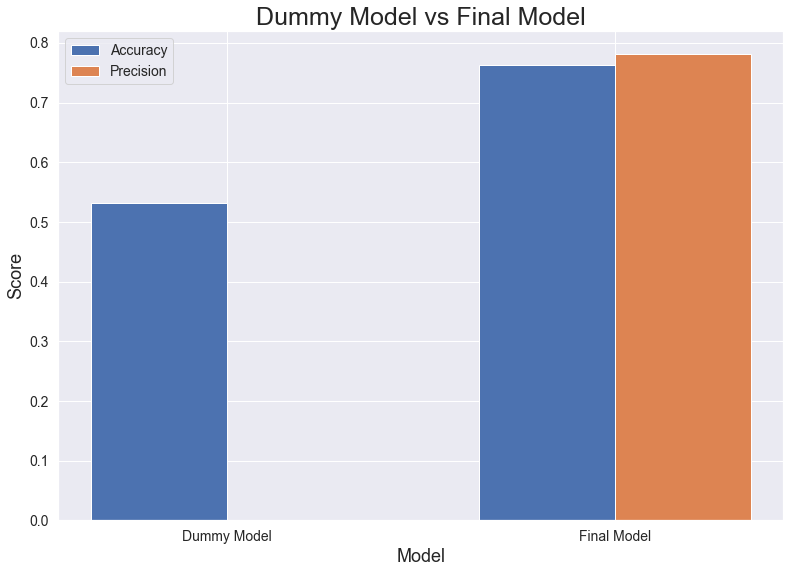

In [462]:
# Data
accuracy_dummy_final = [dummy_mean_acc, rf_final_mean_acc]
precision_dummy_final = [dummy_mean_precision, mean_precision_score_final]

xtick_labels = ['Dummy Model', 'Final Model']

# Set the width of the bars
bar_width = 0.35

# Set the x coordinates for each xtick
x_dummy = [0, 1]
x_final = [x + bar_width for x in x_dummy]

# Create the bar plots
fig, ax = plt.subplots(figsize=(13,9))

plt.bar(x_dummy, accuracy_dummy_final, width=bar_width, label='Accuracy')
plt.bar(x_final, precision_dummy_final, width=bar_width, label='Precision')

# Set the xtick labels
plt.xticks([x + bar_width/2 for x in range(len(xtick_labels))], xtick_labels)

# Set the axis labels and title
plt.title('Dummy Model vs Final Model', fontsize=25)
plt.xlabel('Model', fontsize=18)
plt.ylabel('Score', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add the legend
plt.legend(fontsize=14)

# plt.savefig('images/dummy_vs_final.png')
;

### Importance Score

The decrease in impurity achieved by each feature is calculated as the sum of the impurity decreases over all the trees in the forest. Therefore, the more a feature is used to split the data, and the higher the reduction in impurity it achieves, the more important that feature is considered to be.

Since impurity measures the degree of uncertainty or randomness in the data, a decrease in impurity means that the data becomes more structured and less random after splitting on a particular feature. This indicates that the feature is informative and helps in reducing the overall uncertainty in the model, and thus is considered more important.

Therefore, in random forest models, features that contribute the most to the reduction of impurity are considered the most important features.

In [368]:
importances = rf_final_model.feature_importances_
indices = np.argsort(importances)[::-1]

top_k_features = []
for f in range(10):
    feature_name = X_train.columns[indices[f]]
    importance_score = importances[indices[f]]
    top_k_features.append((feature_name, importance_score))

print("Top 10 features:")
for feature in top_k_features:
    print(f"{feature[0]}: {feature[1]:.4f}")

Top 10 features:
opinion_seas_risk: 0.2027
doctor_recc_seasonal: 0.1784
opinion_seas_vacc_effective: 0.1672
age_group: 0.0888
opinion_h1n1_risk: 0.0436
doctor_recc_h1n1: 0.0426
opinion_h1n1_vacc_effective: 0.0384
chronic_med_condition: 0.0239
household_children: 0.0173
h1n1_concern: 0.0166


#### Top 10 features
Creating a bar chart of the top 10 features and their importance scores.

In [1]:
# changing the names of the x-tick labels so that it is more understandable.
feature_names = ['opinion on risk flu', "doctor's recommendation flu", 'opinion on vaccine effectiveness', 
                 'age group', 'opinion on risk H1N1', "doctor's recommendation H1N1",
                 'opinion on H1N1 effectiveness', 
                 'chronic conditions', 'number of children', 'H1N1 concern']

# importing re so that I can make the long x-tick labels more readable.
import re
xlabels_new = [label.replace(' ', ' \n') for label in feature_names]

# setting up the plot
fig, ax = plt.subplots(figsize=(15,10))

plt.title('Top 10 Features by Importance Score', fontsize=25)

plt.bar([x[0] for x in top_k_features], [x[1] for x in top_k_features])

# change the color of the second and fourth bars
ax.patches[1].set_facecolor('orange')
ax.patches[3].set_facecolor('orange')

plt.xticks(range(len(top_k_features)), xlabels_new, rotation=0, fontsize=14)
plt.xlabel('Features', fontsize=18)
plt.ylabel('Importance Score', fontsize=18)

# plt.savefig('images/top_10_features.png')
;

NameError: name 'plt' is not defined

# LR Final Model

Decided to not use this becasue the precision score for the random forest model ended up being higher.

In [284]:
final_lr = LogisticRegression(C=1)
final_lr.fit(X_train_sc, y_train)

# Predicting
y_pred_lr_final = final_lr.predict(X_train_sc)


print(classification_report(y_train, y_pred_lr_final))
print(confusion_matrix(y_train, y_pred_lr_final))

# Getting accuracy and precision scores of train set
final_lr_acc = accuracy_score(y_train, y_pred_lr_final)
final_lr_prec = precision_score(y_train, y_pred_lr_final)
print()
print(f"The final logistic regression model accuracy is: {final_lr_acc*100 :.2f}%.")
print(f"The final logistic regression model precission is: {final_lr_prec*100 :.2f}%.")

              precision    recall  f1-score   support

           0       0.78      0.81      0.79      9930
           1       0.77      0.73      0.75      8764

    accuracy                           0.77     18694
   macro avg       0.77      0.77      0.77     18694
weighted avg       0.77      0.77      0.77     18694

[[8034 1896]
 [2326 6438]]

The final logistic regression model accuracy is: 77.42%.
The final logistic regression model precission is: 77.25%.


In [252]:
# Cross validation for calassification ives us accuracy by default
cv_lr_final = cross_validate(final_lr, X_train_sc, y_train, cv=5)

# Getting the mean accuracy score
lr_final_mean_acc = cv_lr_final['test_score'].mean()

# Printing the result
print(f"The mean cross validation accuracy of the final logistic regression model is {lr_final_mean_acc:.4f}.")

The mean cross validation accuracy of the final logistic regression model is 0.7728.


In [253]:
# Cross-validation
lr_final_cv_results = cross_val_score(final_lr, X_train_sc, y_train, cv=5, scoring='precision')

# Getting the mean precision score
lr_final_mean_precision = gnb_base_cv_results.mean()

# Printing the result
print(f"The mean cross validation precision of the final logistic regression model is: {lr_final_mean_precision:.4f}")

The mean cross validation precision of the final logistic regression model is: 0.6698


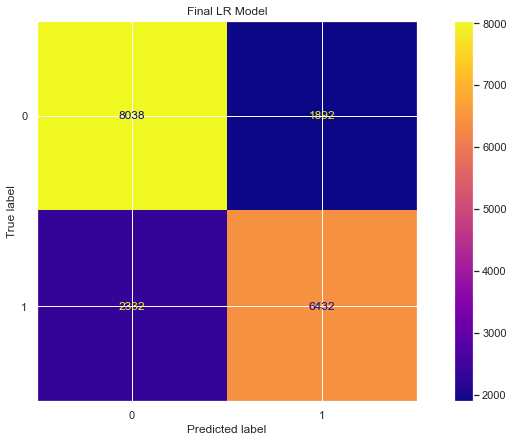

In [275]:
fig, ax = plt.subplots()

plt.title("Final LR Model")

plot_confusion_matrix(final_lr, X_train_sc, y_train, ax=ax, cmap="plasma");

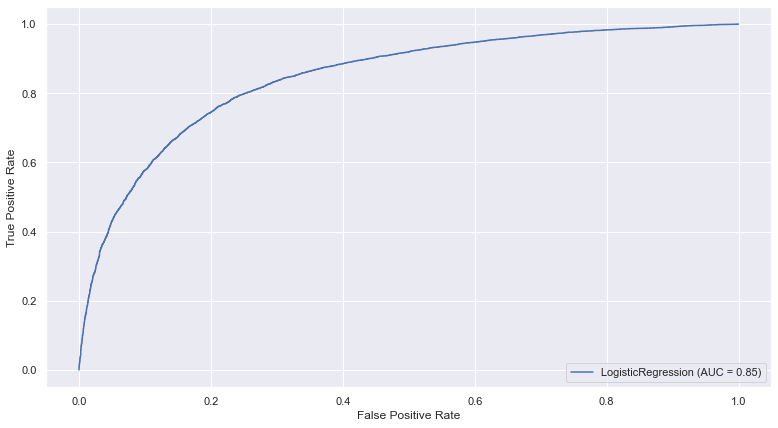

In [277]:
plot_roc_curve(final_lr, X_train_sc, y_train);

# Conclusion